In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm

import pandas as pd
import numpy as np 
import os
import os.path as osp
import pandas as pd

from rdkit.Chem import rdmolops
from scipy.sparse import coo_matrix

from rdkit import Chem 
import random
import networkx as nx
import matplotlib.pyplot as plt

from captum.attr import Saliency, IntegratedGradients


In [2]:
 
import torch
from torch.nn import Linear
import torch.nn.functional as F



In [3]:
from torch_geometric.nn import GraphConv, global_add_pool
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset, Data, download_url 
from torch_geometric.utils import to_networkx

c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [4]:
import deepchem as dc

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [13]:
print(dataset[23].edge_index.t())
print(dataset[23].x)
print(dataset[23].edge_attr)
print(dataset[23].y)

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 5,  7],
        [ 7,  5],
        [ 7,  8],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [10,  9],
        [ 9, 11],
        [11,  9],
        [11, 12],
        [12, 11],
        [ 4, 13],
        [13,  4],
        [13, 14],
        [14, 13],
        [14, 15],
        [15, 14],
        [13, 16],
        [16, 13],
        [16, 17],
        [17, 16],
        [17,  2],
        [ 2, 17]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 

In [12]:
from torch_geometric.loader import DataLoader  # Import from torch_geometric

test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [7]:

#############################################################3
##########THIS WORKS##########################################################

import pandas as pd
import torch
from torch_geometric.data import Dataset
import numpy as np 
import os
from tqdm import tqdm
import deepchem as dc
from rdkit import Chem
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

class DopingDataset(Dataset):
    def __init__(self, root, filename, atom_map, test=False, transform=None, pre_transform=None):
        self.test = test
        self.filename = filename
        self.atom_map = atom_map
        super(DopingDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol = Chem.MolFromSmiles(row["SMILES"])
            if mol is None:
                print(f"Invalid SMILES string at index {index}: {row['SMILES']}")
                continue
            try:
                f = featurizer._featurize(mol)
                if len(f.edge_index) == 0 or f.edge_features is None or f.edge_features.size == 0:
                    print(f"No bonds found in molecule at index {index}: {row['SMILES']}")
                    continue
                data = f.to_pyg_graph()
                data.y = self._get_label(row["Doping"])
                data.smiles = row["SMILES"]
                data.atom_indices = [self.atom_map.index(atom.GetSymbol()) for atom in mol.GetAtoms()]
                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{index}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        try:
            if self.test:
                data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
            else:
                data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))        
            return data
        except FileNotFoundError:
            print(f"File not found for index {idx}, skipping.")
            return None


In [8]:
def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
   
    # Prepare node labels
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    # Generate positions for the nodes
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    # Set edge colors and widths
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    # Draw edge labels if required
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')
    
    # Show the plot
    plt.show()

def to_molecule(data, atom_map):
    g = to_networkx(data, node_attrs=['x'])
   
    for u, node_data in g.nodes(data=True):
        atom_idx = data.atom_indices[u]
        node_data['name'] = atom_map[atom_idx]
        del node_data['x']
    return g

In [9]:
ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']

dataset = DopingDataset(root="data_filtered", filename="all_one.csv", atom_map=ATOM_MAP)

valid_data = [data for data in dataset if data is not None]

print(f"Number of valid data points: {len(valid_data)}")

Processing...
100%|██████████| 1366/1366 [00:29<00:00, 45.77it/s]
Done!


Number of valid data points: 1366


In [35]:
data_sample = random.choice(valid_data)
#data_sample = "CC(C)CCNC"
#data_sample = valid_data[507]
print(f"SMILES formula: {data_sample.smiles}")
mol = to_molecule(data_sample, ATOM_MAP)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

AttributeError: 'str' object has no attribute 'node_offsets'

In [11]:
# import torch
# from torch.nn import Linear
# import torch.nn.functional as F
# from torch_geometric.nn import GraphConv, global_add_pool
# from torch_geometric.data import DataLoader

# Define the model
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

# Custom DataLoader to skip missing files
class SafeDataLoader(DataLoader):
    def __iter__(self):
        for data in super().__iter__():
            if data is None:
                continue
            yield data


In [14]:
# Training and testing functions
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = SafeDataLoader(valid_data[:int(0.8*len(valid_data))], batch_size=32, shuffle=True)
test_loader = SafeDataLoader(valid_data[int(0.8*len(valid_data)):], batch_size=32, shuffle=False)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.9511, Train Acc: 0.5513, Test Acc: 0.6058
Epoch: 002, Loss: 0.6970, Train Acc: 0.5430, Test Acc: 0.6131
Epoch: 003, Loss: 0.6688, Train Acc: 0.5476, Test Acc: 0.6131
Epoch: 004, Loss: 0.6648, Train Acc: 0.6053, Test Acc: 0.6131
Epoch: 005, Loss: 0.6517, Train Acc: 0.6300, Test Acc: 0.6204
Epoch: 006, Loss: 0.6517, Train Acc: 0.6401, Test Acc: 0.6496
Epoch: 007, Loss: 0.6624, Train Acc: 0.6016, Test Acc: 0.6168
Epoch: 008, Loss: 0.6510, Train Acc: 0.6392, Test Acc: 0.6095
Epoch: 009, Loss: 0.6482, Train Acc: 0.6484, Test Acc: 0.5912
Epoch: 010, Loss: 0.6421, Train Acc: 0.6667, Test Acc: 0.6387
Epoch: 011, Loss: 0.6250, Train Acc: 0.6767, Test Acc: 0.6679
Epoch: 012, Loss: 0.6269, Train Acc: 0.6676, Test Acc: 0.6642
Epoch: 013, Loss: 0.6086, Train Acc: 0.6786, Test Acc: 0.6788
Epoch: 014, Loss: 0.6314, Train Acc: 0.6859, Test Acc: 0.6825
Epoch: 015, Loss: 0.6674, Train Acc: 0.6016, Test Acc: 0.6095
Epoch: 016, Loss: 0.6332, Train Acc: 0.6639, Test Acc: 0.6642
Epoch: 0

In [19]:
from captum.attr import Saliency, IntegratedGradients
def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out
def explain(method, data, target=1):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes


In [24]:
from collections import defaultdict


def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

Chosen molecule SMILES: CC(C)NC(=O)NS(=O)(=O)C1=C(NC2=CC=CC(C)=C2)C=CN=C1
Integrated Gradients Method - Influential Edges:
Edge (7, 6) with importance 1.0000 connecting S-N
Edge (1, 3) with importance 0.8502 connecting C-N
Edge (13, 12) with importance 0.8489 connecting C-N
Edge (11, 12) with importance 0.8310 connecting C-N
Edge (4, 3) with importance 0.7403 connecting C-N
Edge (4, 6) with importance 0.6928 connecting C-N
Edge (7, 10) with importance 0.6379 connecting S-C
Edge (4, 5) with importance 0.6372 connecting C-O
Edge (7, 8) with importance 0.6253 connecting S-O
Edge (7, 9) with importance 0.6253 connecting S-O
Integrated Gradients Method - Influential Nodes:
Node 1 (C)
Node 3 (N)
Node 4 (C)
Node 5 (O)
Node 6 (N)
Node 7 (S)
Node 8 (O)
Node 9 (O)
Node 10 (C)
Node 11 (C)
Node 12 (N)
Node 13 (C)


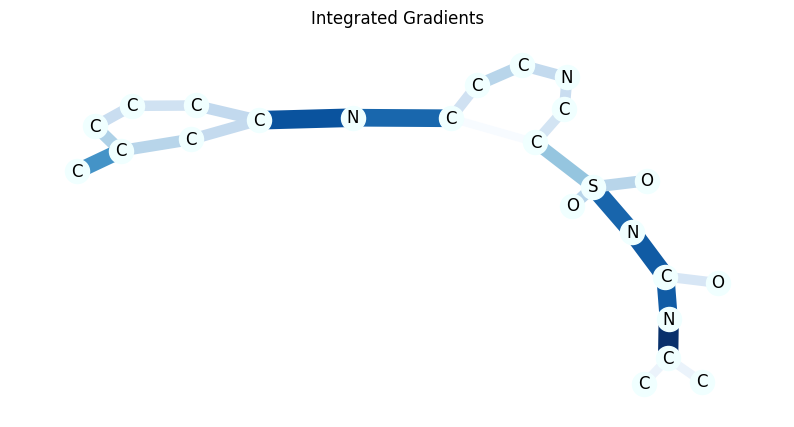

Saliency Method - Influential Edges:
Edge (3, 1) with importance 1.0000 connecting N-C
Edge (6, 7) with importance 0.7165 connecting N-S
Edge (1, 0) with importance 0.6307 connecting C-C
Edge (1, 2) with importance 0.6307 connecting C-C
Edge (14, 13) with importance 0.5868 connecting C-C
Edge (3, 4) with importance 0.5757 connecting N-C
Edge (7, 6) with importance 0.5668 connecting S-N
Edge (6, 4) with importance 0.5377 connecting N-C
Edge (7, 8) with importance 0.5264 connecting S-O
Edge (7, 9) with importance 0.5264 connecting S-O
Saliency Method - Influential Nodes:
Node 0 (C)
Node 1 (C)
Node 2 (C)
Node 3 (N)
Node 4 (C)
Node 6 (N)
Node 7 (S)
Node 8 (O)
Node 9 (O)
Node 13 (C)
Node 14 (C)


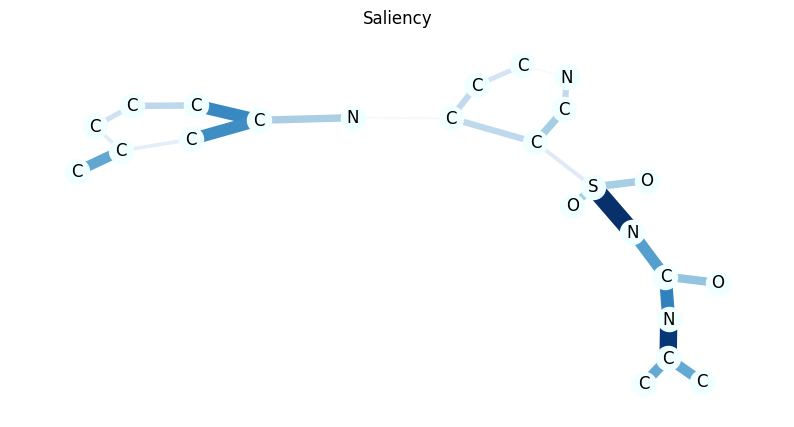

In [42]:

# Example usage with a random molecule from the dataset
#data = random.choice([t for t in test_dataset if not t.y.item()])
data = random.choice(valid_data)
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data, ATOM_MAP)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)